In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Dataset/dataset_final.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head()

,query,intent,response
0,question about cancelling order {{Order Number}},ORDER,I've understood you have a question regarding ...
1,i have a question about cancelling oorder {{Or...,ORDER,I've been informed that you have a question ab...
2,i need help cancelling puchase {{Order Number}},ORDER,I can sense that you're seeking assistance wit...
3,I need to cancel purchase {{Order Number}},ORDER,I understood that you need assistance with can...
4,"I cannot afford this order, cancel purchase {{...",ORDER,I'm sensitive to the fact that you're facing f...


In [ ]:
one_hot = pd.get_dummies(data['intent'])
data.drop(['intent', 'response'], axis=1, inplace=True)
data = pd.concat([data, one_hot], axis=1)
data.head()

,query,ACCOUNT,CANCEL,CONTACT,DELIVERY,FEEDBACK,INVOICE,ORDER,PAYMENT,REFUND,SHIPPING,SUBSCRIPTION
0,question about cancelling order {{Order Number}},0,0,0,0,0,0,1,0,0,0,0
1,i have a question about cancelling oorder {{Or...,0,0,0,0,0,0,1,0,0,0,0
2,i need help cancelling puchase {{Order Number}},0,0,0,0,0,0,1,0,0,0,0
3,I need to cancel purchase {{Order Number}},0,0,0,0,0,0,1,0,0,0,0
4,"I cannot afford this order, cancel purchase {{...",0,0,0,0,0,0,1,0,0,0,0


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
X = data["query"].values
y = data.drop(["query"], axis=1).values

max_features = 20000
maxlen = 150
vocab_size = 20000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=150)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(18810, 150) (18810, 11)
(8062, 150) (8062, 11)


In [ ]:
import pickle

# Save the tokenizer to a file using pickle
with open('/content/drive/MyDrive/Dataset/tokenizer-intent-classification.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


In [ ]:
embed_dim = 50
num_heads = 2
ff_dim = 100

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(11, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping]
)

Epoch 1/10
147/147 [==============================] - 10s 43ms/step - loss: 2.0923 - accuracy: 0.2550 - val_loss: 1.3077 - val_accuracy: 0.6197
Epoch 2/10
147/147 [==============================] - 3s 23ms/step - loss: 0.4117 - accuracy: 0.8835 - val_loss: 0.0404 - val_accuracy: 0.9931
Epoch 3/10
147/147 [==============================] - 3s 19ms/step - loss: 0.0526 - accuracy: 0.9911 - val_loss: 0.0177 - val_accuracy: 0.9963
Epoch 4/10
147/147 [==============================] - 3s 21ms/step - loss: 0.0250 - accuracy: 0.9963 - val_loss: 0.0142 - val_accuracy: 0.9969
Epoch 5/10
147/147 [==============================] - 3s 19ms/step - loss: 0.0160 - accuracy: 0.9979 - val_loss: 0.0163 - val_accuracy: 0.9971
Epoch 6/10
147/147 [==============================] - 3s 18ms/step - loss: 0.0112 - accuracy: 0.9981 - val_loss: 0.0184 - val_accuracy: 0.9970
Epoch 7/10
147/147 [==============================] - 2s 17ms/step - loss: 0.0088 - accuracy: 0.9987 - val_loss: 0.0152 - val_accuracy: 0.997

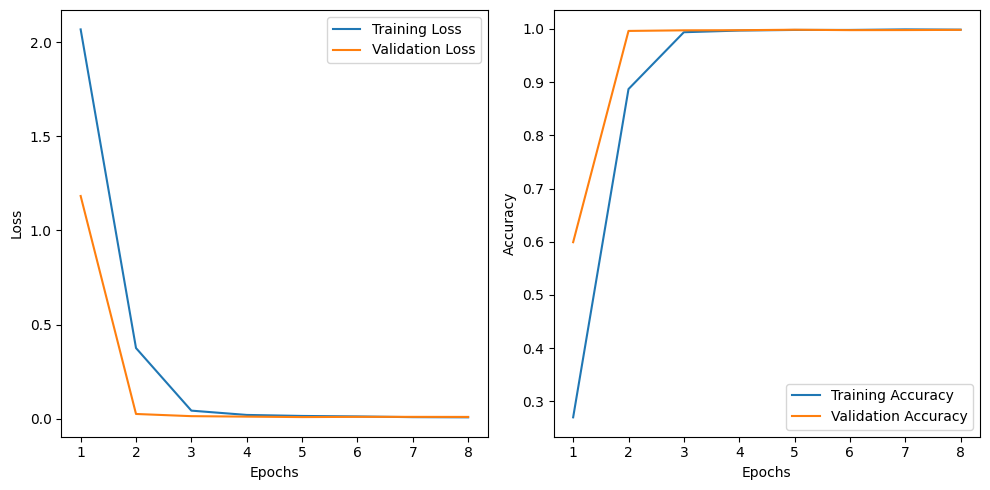

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss and accuracy
epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels)
print(report)

252/252 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1781
           1       0.99      1.00      1.00       301
           2       1.00      1.00      1.00       620
           3       1.00      1.00      1.00       588
           4       1.00      1.00      1.00       610
           5       1.00      1.00      1.00       614
           6       1.00      1.00      1.00      1166
           7       1.00      0.99      0.99       579
           8       1.00      1.00      1.00       922
           9       1.00      1.00      1.00       619
          10       1.00      1.00      1.00       262

    accuracy                           1.00      8062
   macro avg       1.00      1.00      1.00      8062
weighted avg       1.00      1.00      1.00      8062



In [ ]:
model.save("/content/drive/MyDrive/Dataset/IntentClassification.h5")

In [ ]:
text = ["I don't know what to do to see my reimbursement status"]

preprocessed_text = preprocess_sentence(text[0])

text_sequence = tokenizer.texts_to_sequences([preprocessed_text])

text_sequence = pad_sequences(text_sequence, maxlen=maxlen)

intent = model.predict(text_sequence, batch_size=1, verbose=2)[0]

print(np.argmax(intent))

1/1 - 0s - 16ms/epoch - 16ms/step
8
